# Data Preprocessing

This notebook focuses on preprocessing the data for our AED placement optimization project.

## 1. Import Libraries and Set Up Paths

In [9]:
import pandas as pd
import geopandas as gpd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from shapely.ops import nearest_points
import os

# Set base path
base_path = "/Users/Zhuanz/数字游民/mda 项目/mda_project"

# Set up data paths
raw_data_path = os.path.join(base_path, "data", "raw")
processed_data_path = os.path.join(base_path, "data", "processed")

# Create processed data directory if it doesn't exist
os.makedirs(processed_data_path, exist_ok=True)

print("Base path:", base_path)
print("Raw data path:", raw_data_path)
print("Processed data path:", processed_data_path)

Base path: /Users/Zhuanz/数字游民/mda 项目/mda_project
Raw data path: /Users/Zhuanz/数字游民/mda 项目/mda_project/data/raw
Processed data path: /Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed


## 2. Load Data

We'll load the raw data files and handle any potential missing files.

In [14]:
def safe_read_parquet(file_path):
    try:
        return pd.read_parquet(file_path)
    except FileNotFoundError:
        print(f"Warning: File not found: {file_path}")
        return pd.DataFrame()

# Load raw data
aed = safe_read_parquet(os.path.join(raw_data_path, "aed_locations.parquet.gzip"))
ambulance = safe_read_parquet(os.path.join(raw_data_path, "ambulance_locations.parquet.gzip"))
mug = safe_read_parquet(os.path.join(raw_data_path, "mug_locations.parquet.gzip"))
pit = safe_read_parquet(os.path.join(raw_data_path, "pit_locations.parquet.gzip"))
interventions1 = safe_read_parquet(os.path.join(raw_data_path, "interventions1.parquet.gzip"))
interventions2 = safe_read_parquet(os.path.join(raw_data_path, "interventions2.parquet.gzip"))
interventions3 = safe_read_parquet(os.path.join(raw_data_path, "interventions3.parquet.gzip"))
interventions4 = safe_read_parquet(os.path.join(raw_data_path, "interventions_bxl.parquet.gzip"))
interventions5 = safe_read_parquet(os.path.join(raw_data_path, "interventions_bxl2.parquet.gzip"))
cad = safe_read_parquet(os.path.join(raw_data_path, "cad9.parquet.gzip"))

# Load additional data (if available)
try:
    aed_total = pd.read_csv(os.path.join(processed_data_path, "aed_total_coordinates.csv"))
    print("AED total coordinates loaded successfully.")
except FileNotFoundError:
    print("Warning: aed_total_coordinates.csv not found. Skipping this file.")
    aed_total = pd.DataFrame()

try:
    mug1 = pd.read_csv(os.path.join(processed_data_path, "mug1.csv"))
    print("MUG1 data loaded successfully.")
except FileNotFoundError:
    print("Warning: mug1.csv not found. Skipping this file.")
    mug1 = pd.DataFrame()

# Load Belgium shapefile
belgium_shapefile_path = os.path.join(raw_data_path, "BELGIUM_-_Provinces.geojson")
try:
    belgium_with_provinces_boundary = gpd.read_file(belgium_shapefile_path)
    belgium_with_provinces_boundary = belgium_with_provinces_boundary.to_crs(4326)
    print("Belgium shapefile loaded successfully.")
except Exception as e:
    print(f"Warning: Could not load Belgium shapefile. Error: {e}")
    print("Proceeding without Belgium shapefile. Some geographic analyses may be limited.")
    belgium_with_provinces_boundary = gpd.GeoDataFrame()

# Print summary of loaded data
data_frames = {
    'aed': aed,
    'ambulance': ambulance,
    'mug': mug,
    'pit': pit,
    'interventions1': interventions1,
    'interventions2': interventions2,
    'interventions3': interventions3,
    'interventions4': interventions4,
    'interventions5': interventions5,
    'cad': cad,
    'aed_total': aed_total,
    'mug1': mug1,
    'belgium_with_provinces_boundary': belgium_with_provinces_boundary
}

for name, df in data_frames.items():
    if isinstance(df, (pd.DataFrame, gpd.GeoDataFrame)):
        if not df.empty:
            print(f"{name}: {df.shape[0]} rows, {df.shape[1]} columns")
        else:
            print(f"{name}: Empty DataFrame")

AED total coordinates loaded successfully.
MUG1 data loaded successfully.
Belgium shapefile loaded successfully.
aed: 15227 rows, 11 columns
ambulance: 279 rows, 9 columns
mug: 94 rows, 10 columns
pit: 24 rows, 8 columns
interventions1: 200627 rows, 46 columns
interventions2: 200627 rows, 46 columns
interventions3: 200627 rows, 46 columns
interventions4: 115647 rows, 45 columns
interventions5: 38620 rows, 36 columns
cad: 289401 rows, 35 columns
aed_total: 15226 rows, 13 columns
mug1: 73 rows, 12 columns
belgium_with_provinces_boundary: 11 rows, 9 columns


## 3. Define Preprocessing Functions

Here we define the functions needed for data preprocessing.

In [ ]:
def correct_latitude(lat):
    if pd.isna(lat):
        return lat
    if isinstance(lat, (str, float, int)):
        lat_str = str(lat)
        lat_str = re.sub(r'[^0-9-]', '', lat_str)
        if len(lat_str) > 2:
            lat_str = lat_str[:2] + '.' + lat_str[2:]
        return float(lat_str)
    return lat

def correct_longitude(lon):
    if pd.isna(lon):
        return lon
    if isinstance(lon, (str, float, int)):
        lon_str = str(lon)
        lon_str = re.sub(r'[^0-9-]', '', lon_str)
        if len(lon_str) > 1:
            lon_str = lon_str[:1] + '.' + lon_str[1:]
        return float(lon_str)
    return lon

def is_within_belgium(lat, lon):
    belgium_boundaries = {
        'min_latitude': 49.50,
        'max_latitude': 51.50,
        'min_longitude': 2.5,
        'max_longitude': 6.5
    }
    return (belgium_boundaries['min_latitude'] <= lat <= belgium_boundaries['max_latitude']) and \
           (belgium_boundaries['min_longitude'] <= lon <= belgium_boundaries['max_longitude'])

def assign_province(df):
    if 'geometry' not in belgium_with_provinces_boundary.columns:
        print("Warning: Belgium shapefile is not properly loaded. Skipping province assignment.")
        df['Province'] = np.nan
        return df
    
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    joined_gdf = gpd.sjoin(gdf, belgium_with_provinces_boundary, how="left", predicate="intersects")
    df['Province'] = joined_gdf['NAME_2']
    return df

def assign_nearest_province(df, belgium_with_provinces_boundary):
    if 'geometry' not in belgium_with_provinces_boundary.columns:
        print("Warning: Belgium shapefile is not properly loaded. Skipping nearest province assignment.")
        return df
    
    geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
    joined_gdf = gpd.sjoin(gdf, belgium_with_provinces_boundary, how="left", predicate="intersects")
    df['Province'] = joined_gdf['NAME_2']
    unassigned_gdf = gdf[df['Province'].isnull()].copy()
    
    if not unassigned_gdf.empty:
        projected_gdf = unassigned_gdf.to_crs(epsg=31370)
        projected_provinces = belgium_with_provinces_boundary.to_crs(epsg=31370)
        nearest_provinces = []
        
        for idx, point in projected_gdf.iterrows():
            distances = projected_provinces.geometry.distance(point.geometry)
            nearest_idx = distances.idxmin()
            nearest_province = projected_provinces.loc[nearest_idx, 'NAME_2']
            nearest_provinces.append(nearest_province)
        
        unassigned_gdf['Province'] = nearest_provinces
        df.loc[unassigned_gdf.index, 'Province'] = unassigned_gdf['Province']
    
    return df

print("Preprocessing functions defined successfully.")

Preprocessing functions defined successfully.


## 4. Preprocess Intervention Data

In this section, we'll preprocess the intervention datasets, handling potential missing columns and data inconsistencies.

In [22]:
import pandas as pd
import os

# Set paths
base_path = "/Users/Zhuanz/数字游民/mda 项目/mda_project"
raw_data_path = os.path.join(base_path, "data", "raw")
processed_data_path = os.path.join(base_path, "data", "processed")

# Ensure the processed data path exists
os.makedirs(processed_data_path, exist_ok=True)

def safe_read_parquet(file_path):
    try:
        return pd.read_parquet(file_path)
    except Exception as e:
        print(f"Warning: Could not read file {file_path}. Error: {e}")
        return pd.DataFrame()

def preprocess_interventions(df, name):
    print(f"Processing {name}")
    print(f"Original shape: {df.shape}")
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    print(f"Processed shape: {df.shape}")
    return df

# Load and process data
intervention_files = [
    "interventions1.parquet.gzip",
    "interventions2.parquet.gzip",
    "interventions3.parquet.gzip",
    "interventions_bxl.parquet.gzip",
    "interventions_bxl2.parquet.gzip",
    "cad9.parquet.gzip"
]

processed_interventions = []

for file in intervention_files:
    df = safe_read_parquet(os.path.join(raw_data_path, file))
    if not df.empty:
        processed_df = preprocess_interventions(df, file)
        processed_interventions.append(processed_df)

# Combine all processed data
if processed_interventions:
    combined_interventions = pd.concat(processed_interventions, ignore_index=True)
    print(f"\nCombined interventions shape: {combined_interventions.shape}")
    
    # Display some basic information
    print("\nColumn names:")
    print(combined_interventions.columns.tolist())
    
    print("\nData types:")
    print(combined_interventions.dtypes)
    
    # Save processed data
    output_path = os.path.join(processed_data_path, "processed_interventions.csv")
    combined_interventions.to_csv(output_path, index=False)
    print(f"\nProcessed interventions data saved to: {output_path}")
else:
    print("No intervention data to process.")

Processing interventions1.parquet.gzip
Original shape: (200627, 46)
Processed shape: (200627, 46)
Processing interventions2.parquet.gzip
Original shape: (200627, 46)
Processed shape: (200627, 46)
Processing interventions3.parquet.gzip
Original shape: (200627, 46)
Processed shape: (200627, 46)
Processing interventions_bxl.parquet.gzip
Original shape: (115647, 45)
Processed shape: (115647, 45)
Processing interventions_bxl2.parquet.gzip
Original shape: (38620, 36)
Processed shape: (38620, 36)
Processing cad9.parquet.gzip
Original shape: (289401, 35)
Processed shape: (289401, 35)

Combined interventions shape: (1045549, 74)

Column names:
['mission_id', 'service_name', 'postalcode_permanence', 'cityname_permanence', 'streetname_permanence', 'housenumber_permanence', 'latitude_permanence', 'longitude_permanence', 'permanence_short_name', 'permanence_long_name', 'vector_type', 'eventtype_firstcall', 'eventlevel_firstcall', 'eventtype_trip', 'eventlevel_trip', 'postalcode_intervention', 'city

## 5. Preprocess AED Data

In [18]:
if not aed_total.empty:
    aed_total = aed_total[aed_total['public'].isin(['Y', 'y', 'Oui-Ja', 'Ja', 'Oui', 'J', np.nan])]
    aed_total['Latitude'] = aed_total['latitude'].apply(correct_latitude)
    aed_total['Longitude'] = aed_total['longitude'].apply(correct_longitude)
    aed_total['Intervention'] = 0
    aed_total['AED'] = 1
    aed_total['Eventlevel'] = np.nan
    aed_total['EventType'] = 'AED'
    aed_total['T3-T0'] = pd.NaT
    aed_total['Ambulance'] = aed_total['Mug'] = aed_total['PIT'] = 0
    aed_total['Vector type'] = 'AED'
    aed_total['Mission ID'] = 0
    aed_total = assign_province(aed_total)
    aed_total = aed_total[['Mission ID', 'Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType', 
                           'Vector type', 'AED', 'Ambulance', 'Mug', 'PIT', 'Province']]
    print("AED data preprocessed. Shape:", aed_total.shape)
else:
    print("AED data is empty. Skipping preprocessing.")

/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/933484483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_total['Latitude'] = aed_total['latitude'].apply(correct_latitude)
/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/933484483.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_total['Longitude'] = aed_total['longitude'].apply(correct_longitude)
/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/933484483.py:5: SettingWithCopyWarning: 
A value i

AED data preprocessed. Shape: (14006, 13)


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/4065102938.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Province'] = joined_gdf['NAME_2']


## 6. Preprocess Ambulance Data

In [ ]:
if not ambulance.empty:
    ambulance['Latitude'] = ambulance['latitude'].apply(correct_latitude)
    ambulance['Longitude'] = ambulance['longitude'].apply(correct_longitude)
    ambulance['Intervention'] = 0
    ambulance['AED'] = 0
    ambulance['Eventlevel'] = np.nan
    ambulance['EventType'] = 'Ambulance'
    ambulance['T3-T0'] = pd.NaT
    ambulance['Ambulance'] = 1
    ambulance['Mug'] = ambulance['PIT'] = 0
    ambulance['Vector type'] = 'Ambulance'
    ambulance['Mission ID'] = 0
    ambulance = assign_province(ambulance)
    ambulance = ambulance[['Mission ID', 'Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType', 
                           'Vector type', 'AED', 'Ambulance', 'Mug', 'PIT', 'Province']]
    print("Ambulance data preprocessed. Shape:", ambulance.shape)
else:
    print("Ambulance data is empty. Skipping preprocessing.")

Ambulance data preprocessed. Shape: (279, 13)


## 7. Preprocess MUG Data

In [ ]:
if not mug1.empty:
    mug1['Latitude'] = mug1['latitude'].apply(correct_latitude)
    mug1['Longitude'] = mug1['longitude'].apply(correct_longitude)
    mug1['Intervention'] = 0
    mug1['AED'] = 0
    mug1['Eventlevel'] = np.nan
    mug1['EventType'] = 'Mug'
    mug1['T3-T0'] = pd.NaT
    mug1['Ambulance'] = mug1['PIT'] = 0
    mug1['Mug'] = 1
    mug1['Vector type'] = 'MUG'
    mug1['Mission ID'] = 0
    mug1 = assign_province(mug1)
    mug1 = mug1[['Mission ID', 'Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 'EventType', 
                 'Vector type', 'AED', 'Ambulance', 'Mug', 'PIT', 'Province']]
    print("MUG data preprocessed. Shape:", mug1.shape)
else:
    print("MUG data is empty. Skipping preprocessing.")

MUG data preprocessed. Shape: (73, 13)


## 8. Preprocess PIT Data

This section focuses on preprocessing the PIT (Paramedic Intervention Team) data, which requires special handling due to its unique structure.

In [ ]:
import pandas as pd
import numpy as np
import os

def preprocess_pit_data(pit, pit_locations):
    if pit.empty or pit_locations.empty:
        print("PIT data or PIT locations data is empty. Skipping preprocessing.")
        return pd.DataFrame()

    print("Columns in PIT data:", pit.columns)
    print("Columns in PIT locations data:", pit_locations.columns)

    # Extract ID from Medical resource in pit_locations dataframe
    pit_locations['id'] = pit_locations['Medical resource'].str.extract(r'Team: (\w+)')
    
    # Add required columns
    pit_locations['Intervention'] = 0
    pit_locations['AED'] = 0
    pit_locations['Eventlevel'] = np.nan
    pit_locations['EventType'] = 'PIT'
    pit_locations['T3-T0'] = pd.NaT
    pit_locations['Ambulance'] = 0
    pit_locations['Mug'] = 0
    pit_locations['PIT'] = 1
    pit_locations['Vector type'] = 'PIT'
    pit_locations['Mission ID'] = pit_locations['Nr. Fonction PIT']

    # Rename columns
    pit_locations = pit_locations.rename(columns={
        'Latitude': 'Latitude',
        'Longitude': 'Longitude',
        'Province': 'Province'
    })

    # Select required columns
    columns = ['Mission ID', 'Latitude', 'Longitude', 'Intervention', 'Eventlevel', 'T3-T0', 
               'EventType', 'Vector type', 'AED', 'Ambulance', 'Mug', 'PIT', 'Province']
    
    pit_preprocessed = pit_locations.reindex(columns=columns)

    print("PIT data preprocessed. Shape:", pit_preprocessed.shape)
    return pit_preprocessed

# Load PIT locations data
pit_locations_path = os.path.join(base_path, "data", "processed", "pit_01022024_fr.xlsx")
try:
    pit_locations = pd.read_excel(pit_locations_path)
    print("PIT locations data loaded successfully.")
    print("Sample of PIT locations data:")
    print(pit_locations.head())
except FileNotFoundError:
    print(f"Warning: PIT locations file not found at {pit_locations_path}")
    pit_locations = pd.DataFrame()
except Exception as e:
    print(f"Error loading PIT locations data: {e}")
    pit_locations = pd.DataFrame()

# Preprocess PIT data
if not pit_locations.empty:
    pit_preprocessed = preprocess_pit_data(pd.DataFrame(), pit_locations)  # We're not using the 'pit' dataframe

    if not pit_preprocessed.empty:
        print("Sample of preprocessed PIT data:")
        print(pit_preprocessed.head())
        
        # Save the preprocessed PIT data
        output_path = os.path.join(processed_data_path, "pit_preprocessed.csv")
        pit_preprocessed.to_csv(output_path, index=False)
        print(f"Preprocessed PIT data saved to: {output_path}")
    else:
        print("No preprocessed PIT data available.")
else:
    print("PIT locations data is not available or is empty. Skipping PIT data preprocessing.")

PIT locations data loaded successfully.
Sample of PIT locations data:
                           Base                   Medical resource  \
0             BA ESSE AZ Klina         PIT ESSEN (Team: PAESSE01A)   
1        BH CHAR ISPPC Mambourg  PIT CHARLEROI 1 (Team: PHCHAR04A)   
2        FN PDS METT Val Sambre       PIT METTET (Team: PNMETT01A)   
3  FX PDS BOUI Luxembourg | PIT   PIT.BOUILLON 1 (Team: PXBOUI01A)   
4  FX PDS VIRT Luxembourg | PIT     PIT.VIRTON 1 (Team: PXVIRT01A)   

   Nr. Fonction PIT                          Lieu de départ    Province  \
0            104101               Kerkeneind 1 - 2910 ESSEN      Anvers   
1            613001  Boulevard Zoé Drion 1 - 6000 CHARLEROI     Hainaut   
2            620001         Rue Hennevauch 91 - 5640 METTET       Namur   
3            903001    Rue des 4 moineaux 23B - 6832 CURFOZ  Luxembourg   
4            902001      Rue d'Harnoncourt 48 - 6762 VIRTON  Luxembourg   

     Région   Latitude  Longitude  
0   Flandre  51.471093

## 9. Combine All Datasets

In [ ]:
# Combine all preprocessed datasets
all_datasets = [
    interventions_TOTAL,
    aed_total,
    ambulance,
    mug1,
    pit_preprocessed
]

# Filter out any empty DataFrames
all_datasets = [df for df in all_datasets if not df.empty]

if all_datasets:
    total_df = pd.concat(all_datasets, axis=0, ignore_index=True)
    print("All datasets combined. Shape of total_df:", total_df.shape)
else:
    print("Warning: No datasets available to combine. Creating an empty DataFrame.")
    total_df = pd.DataFrame()

# Print summary statistics
if not total_df.empty:
    print('\nUnique number of Latitude values:', len(total_df['Latitude'].unique()))
    print('Unique number of Longitude values:', len(total_df['Longitude'].unique()))
    print('Unique values eventlevels:', total_df['Eventlevel'].unique())

    cross_tab = pd.crosstab(index=pd.Categorical(total_df["Eventlevel"]), columns='count')
    print('\nCross table of Event Levels:\n', cross_tab)

    max_responseTime = total_df['T3-T0'].max()
    print(f'\nMaximum Response Time: {max_responseTime}')
    print('\nMissing values per variable:\n', total_df.isnull().sum())
    print('\nTotal Length of the Dataset:', len(total_df))
    print('\nTypes of variables in dataset:\n', total_df.dtypes)
else:
    print("The combined dataset is empty. Skipping summary statistics.")

All datasets combined. Shape of total_df: (21205, 13)

Unique number of Latitude values: 15390
Unique number of Longitude values: 15427
Unique values eventlevels: [ 1.  2.  0.  5.  7.  6. nan]

Cross table of Event Levels:
 col_0  count
row_0       
0.0     1540
1.0     3989
2.0      559
5.0      713
6.0       40
7.0        6

Maximum Response Time: nan

Missing values per variable:
 Mission ID          0
Latitude            0
Longitude           0
Intervention        0
Eventlevel      14358
T3-T0           21205
EventType           0
Vector type         0
AED                 0
Ambulance           0
Mug                 0
PIT                 0
Province          101
dtype: int64

Total Length of the Dataset: 21205

Types of variables in dataset:
 Mission ID        int64
Latitude        float64
Longitude       float64
Intervention      int64
Eventlevel      float64
T3-T0            object
EventType        object
Vector type      object
AED               int64
Ambulance         int64
Mug  

## 10. Visualizations

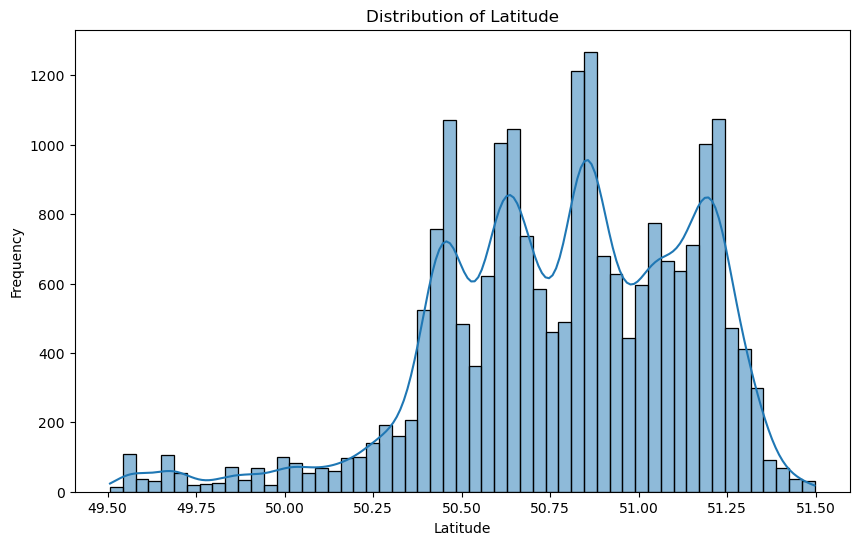

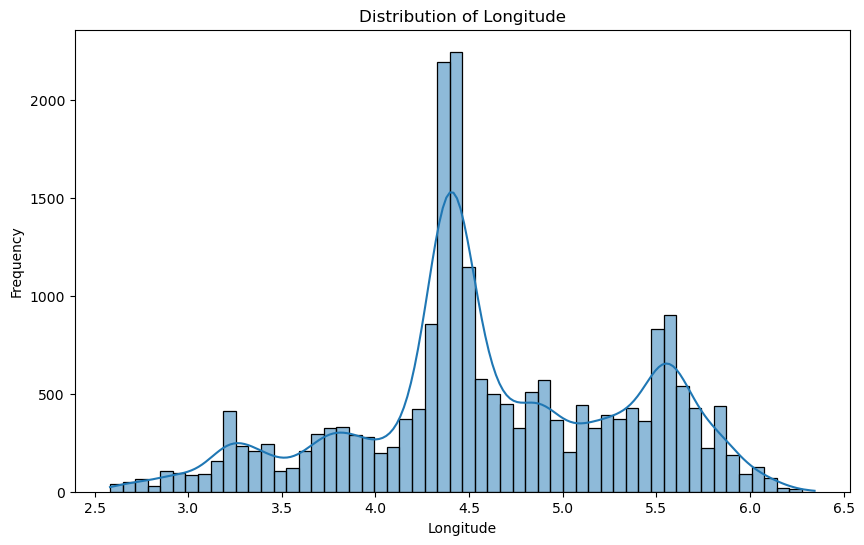

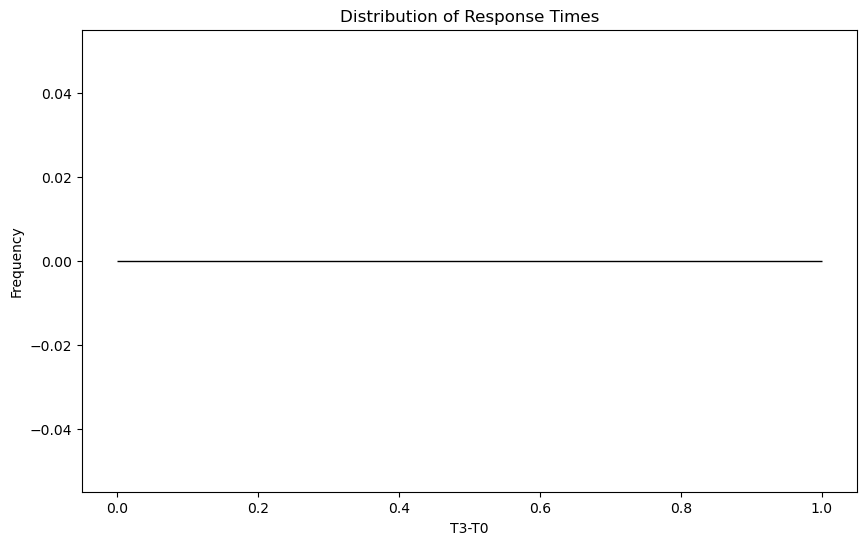

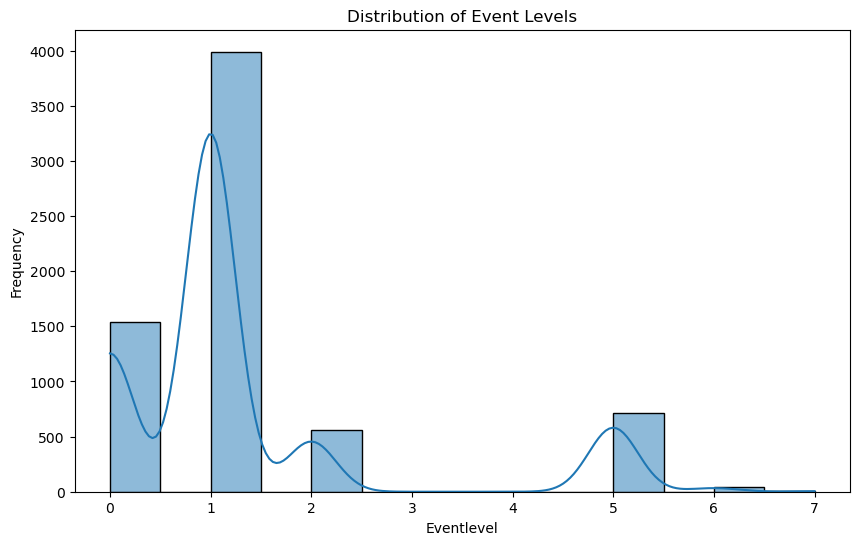

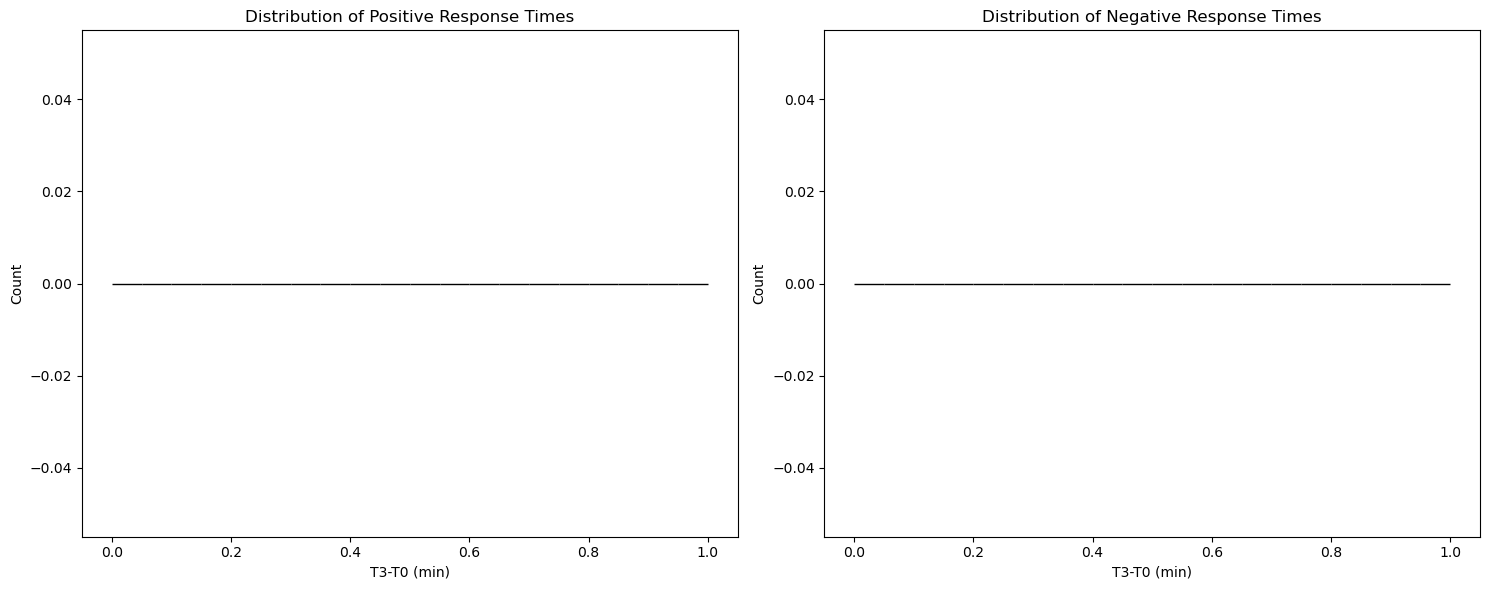

There are 0 negative response times in the dataset


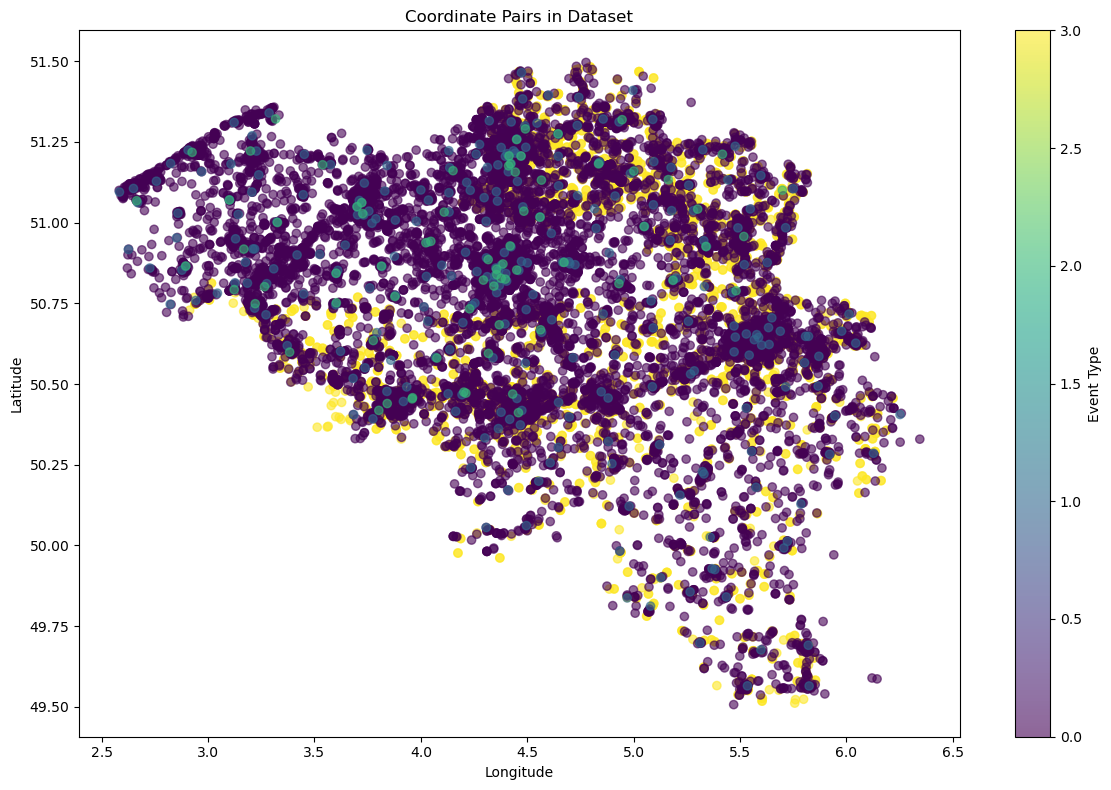

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

if not total_df.empty:
    # Set up the plotting style
    plt.style.use('default')  # Using default style instead of seaborn
    
    # Create a function for histograms
    def plot_histogram(data, column, title, xlabel, ylabel='Frequency'):
        plt.figure(figsize=(10, 6))
        sns.histplot(data=data, x=column, kde=True)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()

    # Plot histograms for Latitude, Longitude, T3-T0, and Eventlevel
    for column, title in [
        ('Latitude', 'Distribution of Latitude'),
        ('Longitude', 'Distribution of Longitude'),
        ('T3-T0', 'Distribution of Response Times'),
        ('Eventlevel', 'Distribution of Event Levels')
    ]:
        plot_histogram(total_df, column, title, column)

    # Plot Response Times for intervention locations
    intervention_locations = total_df[total_df['Intervention'] == 1]
    positive_values = intervention_locations[intervention_locations['T3-T0'] >= 0]
    negative_values = intervention_locations[intervention_locations['T3-T0'] < 0]

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    sns.histplot(data=positive_values, x='T3-T0', bins=20, kde=True, color='green', ax=axes[0])
    axes[0].set_title('Distribution of Positive Response Times')
    axes[0].set_xlabel('T3-T0 (min)')
    sns.histplot(data=negative_values, x='T3-T0', bins=20, kde=True, color='red', ax=axes[1])
    axes[1].set_title('Distribution of Negative Response Times')
    axes[1].set_xlabel('T3-T0 (min)')
    plt.tight_layout()
    plt.show()

    print('There are', len(negative_values), 'negative response times in the dataset')

    # Plot coordinate pairs
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(total_df['Longitude'], total_df['Latitude'], c=total_df['EventType'].astype('category').cat.codes, alpha=0.6, cmap='viridis')
    plt.title('Coordinate Pairs in Dataset')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar(scatter, label='Event Type')
    plt.tight_layout()
    plt.show()
else:
    print("The combined dataset is empty. Skipping visualizations.")

## 11. Data Cleaning and Final Processing


Columns in total_df:
['id', 'type', 'address', 'number', 'postal_code', 'municipality', 'province', 'location', 'public', 'available', 'hours', 'base', 'medical_resource', 'region', 'departure_location', 'departure_location_number', 'Latitude', 'Longitude', 'occasional_permanence', 'hospital_id', 'mug_id', 'campus_id', 'name_hospital', 'name_campus', 'address_campus', 'unit', 'campus', 'unit_id', 'ambucode', 'ambusitecode', 'link', 'Mission ID', 'Service Name', 'PostalCode permanence', 'CityName permanence', 'StreetName permanence', 'HouseNumber permanence', 'Latitude permanence', 'Longitude permanence', 'Permanence short name', 'Permanence long name', 'Vector type', 'EventType Firstcall', 'EventLevel Firstcall', 'EventType Trip', 'EventLevel Trip', 'PostalCode intervention', 'CityName intervention', 'Latitude intervention', 'Longitude intervention', 'Province intervention', 'T0', 'T1', 'T1confirmed', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T9', 'Intervention time (T1Reported)', 'Interve

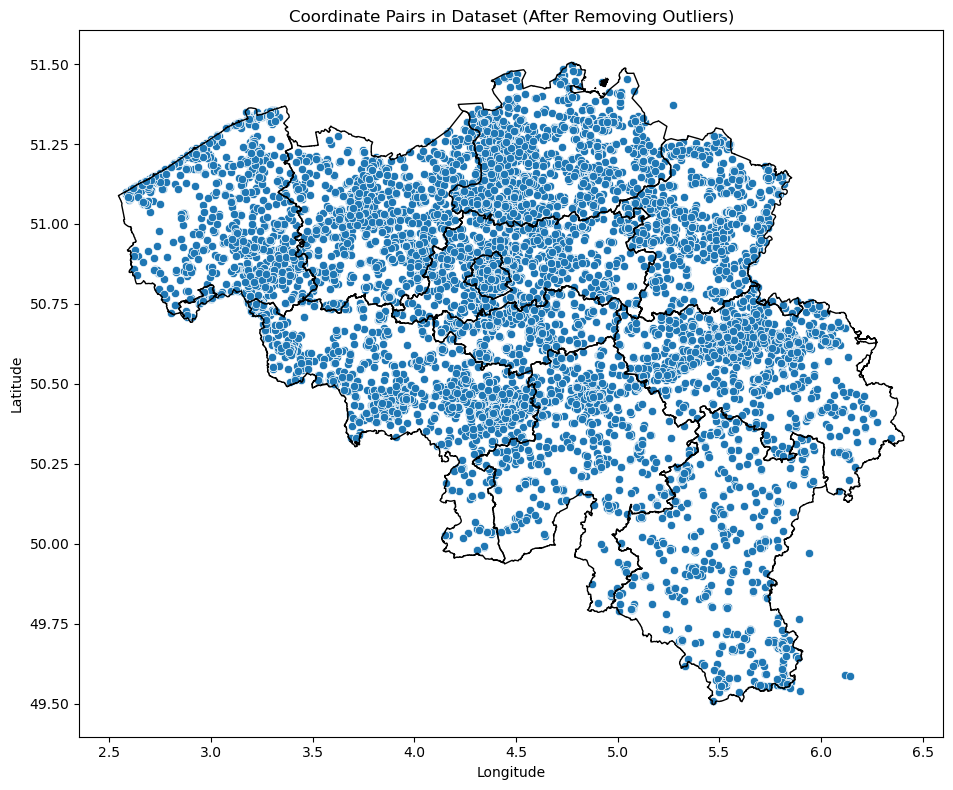

T3-T0 column not found in the dataset.
Data cleaning and final processing completed.
Shape of final dataset: (15488, 163)

Preprocessed dataset saved to: /Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed/total_df_preprocessed.csv


In [13]:
# Continue with analysis
if not total_df.empty:
    print("\nColumns in total_df:")
    print(total_df.columns.tolist())

    # Try to find latitude and longitude columns
    lat_columns = [col for col in total_df.columns if 'latitude' in col.lower()]
    lon_columns = [col for col in total_df.columns if 'longitude' in col.lower()]

    if lat_columns and lon_columns:
        print(f"Found latitude column: {lat_columns[0]}")
        print(f"Found longitude column: {lon_columns[0]}")
        
        # Rename columns
        total_df = total_df.rename(columns={lat_columns[0]: 'Latitude', lon_columns[0]: 'Longitude'})

        # Remove locations outside of Belgium
        total_df = total_df[total_df.apply(lambda row: is_within_belgium(row['Latitude'], row['Longitude']), axis=1)]

        # Plot distribution after removal
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=total_df, x='Longitude', y='Latitude', hue='Province' if 'Province' in total_df.columns else None)
        plt.title('Coordinate Pairs in Dataset (After Removing Outliers)')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        if not belgium_with_provinces_boundary.empty:
            belgium_with_provinces_boundary.plot(ax=plt.gca(), facecolor='none', edgecolor='black')
        if 'Province' in total_df.columns:
            plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Could not find latitude and longitude columns. Skipping geographic filtering and plotting.")

    # Check T3-T0 column
    if 'T3-T0' in total_df.columns:
        print("\nT3-T0 column information:")
        print(total_df['T3-T0'].describe())
        print("\nUnique values in T3-T0:")
        print(total_df['T3-T0'].unique())

        # Convert T3-T0 to timedelta if it's not already
        if not pd.api.types.is_timedelta64_dtype(total_df['T3-T0']):
            total_df['T3-T0'] = pd.to_timedelta(total_df['T3-T0'], unit='m')

        # Set negative Response Times to NaT
        total_df.loc[total_df['T3-T0'] < pd.Timedelta(0), 'T3-T0'] = pd.NaT
        total_df.reset_index(drop=True, inplace=True)

        # Convert timedelta to minutes for plotting
        total_df['T3-T0_minutes'] = total_df['T3-T0'].dt.total_seconds() / 60

        # Plot Response Time distribution
        plt.figure(figsize=(12, 6))
        try:
            sns.histplot(data=total_df.dropna(subset=['T3-T0_minutes']), x='T3-T0_minutes', bins=50, kde=True, hue='Vector type' if 'Vector type' in total_df.columns else None)
            if 'Vector type' in total_df.columns:
                plt.legend(title='Vector Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        except ValueError as e:
            print(f"Error in creating histogram: {e}")
            print("Attempting to create alternative visualizations...")
            
            # Alternative 1: Basic histogram without hue
            plt.hist(total_df['T3-T0_minutes'].dropna(), bins=50)
            
            # Alternative 2: Box plot
            plt.figure(figsize=(12, 6))
            sns.boxplot(x=total_df['T3-T0_minutes'].dropna())
            plt.title('Box Plot of Response Times')
            plt.xlabel('Response Time (min)')
            plt.show()
            
            # Alternative 3: Violin plot (if Vector type is available)
            if 'Vector type' in total_df.columns:
                plt.figure(figsize=(12, 6))
                sns.violinplot(x='Vector type', y='T3-T0_minutes', data=total_df.dropna(subset=['T3-T0_minutes']))
                plt.title('Violin Plot of Response Times by Vector Type')
                plt.xlabel('Vector Type')
                plt.ylabel('Response Time (min)')
                plt.show()
        
        plt.title('Distribution of Response Times')
        plt.xlabel('Response Time (min)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("T3-T0 column not found in the dataset.")

    print("Data cleaning and final processing completed.")
    print("Shape of final dataset:", total_df.shape)
else:
    print("The combined dataset is empty. Skipping data cleaning and final processing.")

# Save the preprocessed dataset
if not total_df.empty:
    output_path = os.path.join(processed_data_path, "total_df_preprocessed.csv")
    total_df.to_csv(output_path, index=False)
    print(f"\nPreprocessed dataset saved to: {output_path}")

## 12.Set negative Response Times to pd.NaT

Processing interventions1.parquet.gzip
Original shape: (200627, 46)


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['t0'] = pd.to_datetime(df['t0'], errors='coerce')


Processed shape: (200627, 48)
Processing interventions2.parquet.gzip
Original shape: (200627, 46)


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['t0'] = pd.to_datetime(df['t0'], errors='coerce')


Processed shape: (200627, 48)
Processing interventions3.parquet.gzip
Original shape: (200627, 46)


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['t0'] = pd.to_datetime(df['t0'], errors='coerce')


Processed shape: (200627, 48)
Processing interventions_bxl.parquet.gzip
Original shape: (115647, 45)


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:32: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['t0'] = pd.to_datetime(df['t0'], errors='coerce')
/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:34: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df['t3-t0'] = df['t3'] - df['t0']


Processed shape: (115647, 46)
Processing interventions_bxl2.parquet.gzip
Original shape: (38620, 36)


/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['t0'] = pd.to_datetime(df['t0'], errors='coerce')
/var/folders/yf/z4xgk8sn7b99hz2zwwrwyj800000gp/T/ipykernel_25402/3203557101.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['t3'] = pd.to_datetime(df['t3'], errors='coerce')


Processed shape: (38620, 38)
Processing cad9.parquet.gzip
Original shape: (289401, 35)
Processed shape: (289401, 37)

Combined interventions shape: (1045549, 76)

Column names:
['mission_id', 'service_name', 'postalcode_permanence', 'cityname_permanence', 'streetname_permanence', 'housenumber_permanence', 'latitude_permanence', 'longitude_permanence', 'permanence_short_name', 'permanence_long_name', 'vector_type', 'eventtype_firstcall', 'eventlevel_firstcall', 'eventtype_trip', 'eventlevel_trip', 'postalcode_intervention', 'cityname_intervention', 'latitude_intervention', 'longitude_intervention', 'province_intervention', 't0', 't1', 't1confirmed', 't2', 't3', 't4', 't5', 't6', 't7', 't9', 'intervention_time_(t1reported)', 'intervention_time_(t1confirmed)', 'waiting_time', 'intervention_duration', 'departure_time_(t1reported)', 'departure_time_(t1confirmed)', 'unavailable_time', 'name_destination_hospital', 'postalcode_destination_hospital', 'cityname_destination_hospital', 'streetname

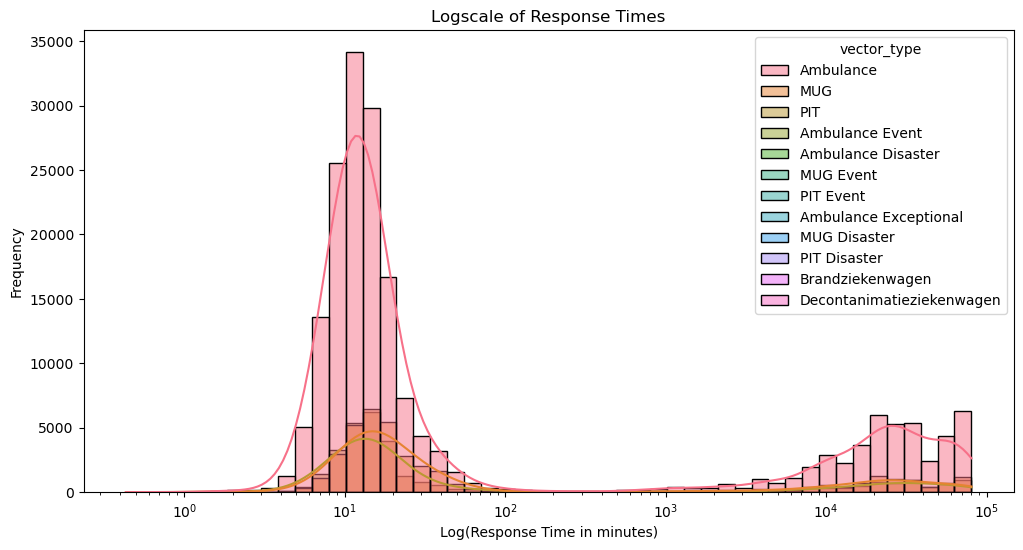


Processed interventions data saved to: /Users/Zhuanz/数字游民/mda 项目/mda_project/data/processed/processed_interventions.csv


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set paths
base_path = "/Users/Zhuanz/数字游民/mda 项目/mda_project"
raw_data_path = os.path.join(base_path, "data", "raw")
processed_data_path = os.path.join(base_path, "data", "processed")

# Ensure the processed data path exists
os.makedirs(processed_data_path, exist_ok=True)

def safe_read_parquet(file_path):
    try:
        return pd.read_parquet(file_path)
    except Exception as e:
        print(f"Warning: Could not read file {file_path}. Error: {e}")
        return pd.DataFrame()

def preprocess_interventions(df, name):
    print(f"Processing {name}")
    print(f"Original shape: {df.shape}")
    
    # Standardize column names
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Attempt to process time columns if they exist
    if 't0' in df.columns and 't3' in df.columns:
        try:
            df['t0'] = pd.to_datetime(df['t0'], errors='coerce')
            df['t3'] = pd.to_datetime(df['t3'], errors='coerce')
            df['t3-t0'] = df['t3'] - df['t0']
            
            # Set negative response times to NaT
            df.loc[df['t3-t0'] < pd.Timedelta(0), 't3-t0'] = pd.NaT
            
            # Convert timedelta to minutes
            df['response_time_minutes'] = df['t3-t0'].dt.total_seconds() / 60
        except Exception as e:
            print(f"Warning: Error processing time columns in {name}. Error: {e}")
    
    print(f"Processed shape: {df.shape}")
    return df

# Load and process data
intervention_files = [
    "interventions1.parquet.gzip",
    "interventions2.parquet.gzip",
    "interventions3.parquet.gzip",
    "interventions_bxl.parquet.gzip",
    "interventions_bxl2.parquet.gzip",
    "cad9.parquet.gzip"
]

processed_interventions = []

for file in intervention_files:
    df = safe_read_parquet(os.path.join(raw_data_path, file))
    if not df.empty:
        processed_df = preprocess_interventions(df, file)
        processed_interventions.append(processed_df)

# Combine all processed data
if processed_interventions:
    combined_interventions = pd.concat(processed_interventions, ignore_index=True)
    print(f"\nCombined interventions shape: {combined_interventions.shape}")
    
    # Display some basic information
    print("\nColumn names:")
    print(combined_interventions.columns.tolist())
    
    print("\nData types:")
    print(combined_interventions.dtypes)
    
    # Plot distribution of response times
    if 'response_time_minutes' in combined_interventions.columns:
        plt.figure(figsize=(12, 6))
        try:
            sns.histplot(data=combined_interventions, 
                         x='response_time_minutes', 
                         bins=50, 
                         log_scale=True, 
                         kde=True, 
                         hue='vector_type')
            plt.title('Logscale of Response Times')
            plt.xlabel('Log(Response Time in minutes)')
            plt.ylabel('Frequency')
            plt.show()
        except Exception as e:
            print(f"Warning: Error creating histogram. Error: {e}")
    
    # Save processed data
    output_path = os.path.join(processed_data_path, "processed_interventions.csv")
    combined_interventions.to_csv(output_path, index=False)
    print(f"\nProcessed interventions data saved to: {output_path}")
else:
    print("No intervention data to process.")